In [2]:
!pip install efficientnet_pytorch

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet

In [4]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        self.classes = self.data['hotel_id'].unique().tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[idx, 1]), str(self.data.iloc[idx, 0]))
        image = Image.open(img_name).convert("RGB")
        label = self.classes.index(self.data.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
train_dataset = CustomDataset('train.csv', 'final/train_images', transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

model = EfficientNet.from_pretrained('efficientnet-b0')
num_features = model._fc.in_features
model._fc = nn.Linear(num_features, len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Loaded pretrained weights for efficientnet-b0


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [13]:
num_epochs = 10
best_accuracy = 0.0  # Track the best validation accuracy

In [14]:
train_losses = []  
val_losses = []  

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Iteration {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    # Save model checkpoint after each epoch
    checkpoint_path = os.path.join("checkpoints", f"efficientnet-b0_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")
    
    # Validation
    val_dataset = CustomDataset('validation.csv', 'final/validation_images', transform=data_transforms)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
    correct = 0
    total = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    
    # Update best accuracy and save best model checkpoint
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_checkpoint_path = os.path.join("checkpoints", "efficientnet-b0_best_checkpoint.pth")
        torch.save(model.state_dict(), best_checkpoint_path)

Iteration 1/1072, Loss: 8.0216
Iteration 2/1072, Loss: 7.9548
Iteration 3/1072, Loss: 7.9567
Iteration 4/1072, Loss: 7.9579
Iteration 5/1072, Loss: 8.0003
Iteration 6/1072, Loss: 8.0103
Iteration 7/1072, Loss: 7.9899
Iteration 8/1072, Loss: 7.9685
Iteration 9/1072, Loss: 8.0483
Iteration 10/1072, Loss: 7.9695
Iteration 11/1072, Loss: 8.0151
Iteration 12/1072, Loss: 8.0471
Iteration 13/1072, Loss: 7.9698
Iteration 14/1072, Loss: 7.9923
Iteration 15/1072, Loss: 7.9362
Iteration 16/1072, Loss: 7.9968
Iteration 17/1072, Loss: 8.0134
Iteration 18/1072, Loss: 7.9999
Iteration 19/1072, Loss: 7.9504
Iteration 20/1072, Loss: 8.0040
Iteration 21/1072, Loss: 7.9802
Iteration 22/1072, Loss: 8.0226
Iteration 23/1072, Loss: 8.0174
Iteration 24/1072, Loss: 7.9674
Iteration 25/1072, Loss: 8.0241
Iteration 26/1072, Loss: 7.9192
Iteration 27/1072, Loss: 7.9585
Iteration 28/1072, Loss: 8.0350
Iteration 29/1072, Loss: 7.9736
Iteration 30/1072, Loss: 7.9973
Iteration 31/1072, Loss: 7.9063
Iteration 32/1072

ValueError: x and y must have same first dimension, but have shapes (10,) and (11,)

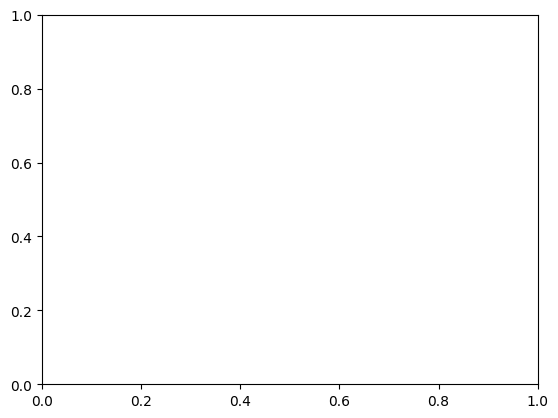

In [17]:
import matplot
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()